In this note book we will model No2 concentrations over time using Support Vector Machines

# I. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('No2_Final.csv')

In [3]:
df.tail()

,Date,No2_con,No2_AQI
67,20-Aug,15.302607,14.103647
68,20-Sep,21.624505,20.090636
69,20-Oct,25.384008,23.651372
70,20-Nov,26.773001,24.949670
71,20-Dec,26.970831,25.119968


In [4]:
# No null data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     72 non-null     object 
 1   No2_con  72 non-null     float64
 2   No2_AQI  72 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.8+ KB


# II. Prepare Data

We will first convert the date column to a datetime object

In [5]:
dat = np.repeat(20, 72, axis=0).astype(str)  + df["Date"].astype(str) 
dat = pd.to_datetime(dat)
end = dat + pd.offsets.MonthBegin(1) - datetime.timedelta(days = 1)
df['Date'] = end

In [6]:
df.head()

,Date,No2_con,No2_AQI
0,2015-01-31,26.099693,24.371845
1,2015-02-28,23.780465,22.197916
2,2015-03-31,22.807790,21.261101
3,2015-04-30,18.717231,17.420677
4,2015-05-31,12.130075,11.219968


Since the SVR model takes in the date column as integers we must integerize our date column

In [7]:
df['Date'] = df['Date'].apply(lambda x: x.toordinal())

In [8]:
df.head()

,Date,No2_con,No2_AQI
0,735629,26.099693,24.371845
1,735657,23.780465,22.197916
2,735688,22.807790,21.261101
3,735718,18.717231,17.420677
4,735749,12.130075,11.219968


Prepare date and concentration columns as lists

In [9]:
# X columns
days = list()
# y column
cons = list()

In [10]:
df_date = df.loc[:,'Date']
df_con = df.loc[:,'No2_con']

In [11]:
for day in df_date:
    days.append([int(day)])  
for con in df_con:
    cons.append(float(con))

In [12]:
print(days[0:5])
print(cons[0:5])

[[735629], [735657], [735688], [735718], [735749]]
[26.09969271, 23.78046522, 22.80778955, 18.71723094, 12.13007508]


Before splitting our data into training and testing data for our model, we set a random seed to ensure that the random values the code generates will be the same everytime it is run. This is so that our evaluations and explanations of our models are consistent with the model outputs.

In [13]:
np.random.seed(1234)

We will use `train_test_split` from the sklearn module to split the raw data into two sets: training set and testing set at the proportion 70 : 30

In [14]:
x_train, x_test, y_train, y_test = train_test_split(days, cons, test_size=0.3)

# III.  Support Vector Regression Model

For this SVR time series model we will use the rbf kernel. Let's start by training a model with the default parameters 

In [15]:
rbf = SVR(kernel= 'rbf')
rbf.fit(x_train,y_train)

SVR()

In [16]:
print('RMSE value of the SVR Model is:', np.sqrt(metrics.mean_squared_error(y_test, rbf.predict(x_test))))
print('R squared score of the SVR Model is: ', rbf.score(x_train,y_train))

RMSE value of the SVR Model is: 6.175577057941007
R squared score of the SVR Model is:  0.04347295506711257


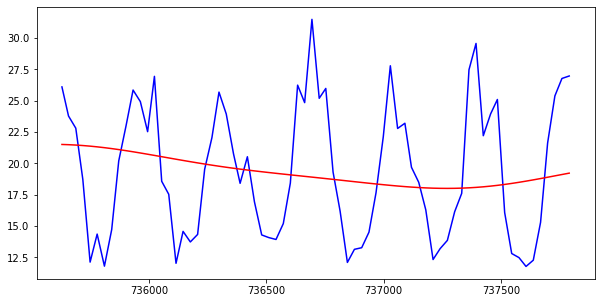

In [17]:
# Plot results
plt.figure(figsize=(10,5))
plt.plot(days,cons, color="blue")
plt.plot(days, rbf.predict(days), color='red')

As we can see this is a smoothed model and it fails to capture the fluctuations in our data. To improve this we will use gridsearch to tune select parameters

In [18]:
param = {'C' : [1,10,1000],'epsilon':[0.1,0.2,0.5,0.3],'gamma': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
modelsvr = SVR(kernel='rbf')
grids = GridSearchCV(modelsvr,param,cv=5)

In [19]:
grids.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=({'C': [1, 10, 1000], 'epsilon': [0.1, 0.2, 0.5, 0.3],
                          'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                    0.01, 0.1]},))

In [20]:
print("best parameters are: ", grids.best_params_)

best parameters are:  {'C': 10, 'epsilon': 0.5, 'gamma': 0.0001}


We train a model using the follwing two parameters

In [21]:
best_rbf = SVR(kernel= 'rbf', C= 10, epsilon = 0.5, gamma = 0.0001)
best_rbf.fit(x_train,y_train)

SVR(C=10, epsilon=0.5, gamma=0.0001)

In [22]:
print('RMSE value of the SVR Model is:', np.sqrt(metrics.mean_squared_error(y_test, best_rbf.predict(x_test))))
print('R squared score of the SVR Model is: ', best_rbf.score(x_train,y_train))

RMSE value of the SVR Model is: 3.0685058155240577
R squared score of the SVR Model is:  0.9111988255647572


In [23]:
x = []
for sublist in x_test:
    for item in sublist:
        x.append(item)
        
y = list(zip(y_test, best_rbf.predict(x_test)))

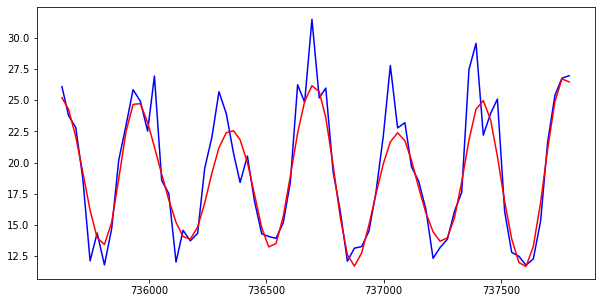

In [26]:
plt.figure(figsize=(10,5))
plt.plot(days,cons, color="blue")
plt.plot(days, best_rbf.predict(days), color='red')
plt.show()

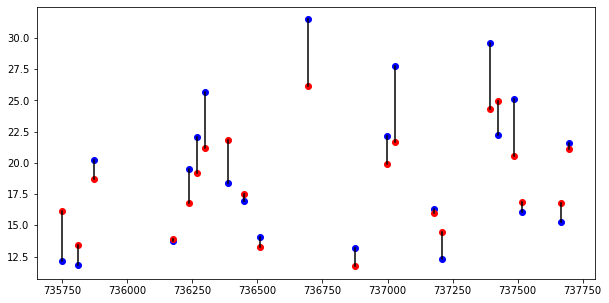

In [27]:
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test, color="blue")
plt.scatter(x_test, best_rbf.predict(x_test), color='red')
plt.plot((x,x),([i for (i,j) in y], [j for (i,j) in y]),c='black')
plt.show()

As we can see the results are much better. The fluctation in the data is captured and our RMSE and R-squared values have also improved.

In [28]:
print(best_rbf.predict(x_test))
print(y_test)

[19.91032231 16.88421889 21.66458359 16.00153002 13.44131712 13.24688159
 24.97662722 17.479674   18.70396018 21.20775112 19.18100422 16.18212173
 21.8325088  20.5138592  14.46302969 16.78166859 13.87397356 21.07955195
 24.28974169 26.17096376 11.7060611  16.75051362]
[22.13688907, 16.08530984, 27.78537632, 16.29428991, 11.80746749, 14.08617257, 22.20904548, 16.9430141, 20.20115076, 25.68588883, 22.06108915, 12.13007508, 18.41280954, 25.09714651, 12.33432212, 15.30260661, 13.73819223, 21.62450487, 29.56607159, 31.48716085, 13.14884763, 19.53460323]
